Code to develop code to train models across multiple GPUS

In [1]:
%load_ext autoreload
%autoreload 2

In [185]:
import matplotlib.pyplot as plt

import torch

In [38]:
n_gpu = torch.cuda.device_count()
devices = [torch.device('cuda:'+str(i)) for i in range(n_gpu)]

#### Parameters go here

In [99]:
input_d = 10
n_smps = 100 

In [172]:
class ExModel(torch.nn.Module):
    
    def __init__(self, n, devices):
        """ Creates a new ExModel object. 
        
        Arg:
            n: The dimensionality of the input
            
            devices: A list of devices to distribute model on.  Should be of length 2. 
        
        """
        
        super().__init__()
        
        p = torch.zeros([1, n], device=devices[0])
        self.p = torch.nn.Parameter(p)
        torch.nn.init.xavier_normal_(self.p)
        
        u = torch.zeros([1, 1], device=devices[1])
        u.data[:] = 2.0
        self.u = torch.nn.Parameter(u)
        
        self.devices = devices
        
    def forward(self, x: torch.Tensor):
        """ Compute mean input from output """
        l = torch.matmul(self.p, 10*x.t())
        l = l.to(self.devices[1])
        return torch.matmul(self.u, l)
    
    def gen_output(self, x: torch.Tensor):
        """ Simulate output (mean + noise) from input. """
        with torch.no_grad():
            mn = self.forward(x)
            noise = torch.randn_like(mn)
        return [mn + noise, mn]

#### Generate true data and model

In [173]:
true_mdl = ExModel(n=input_d, devices=devices)
x = torch.randn([n_smps, input_d], device=devices[0])
data_true, mn_true = true_mdl.gen_output(x)

### Train a new model

In [178]:
fit_mdl = ExModel(n=input_d, devices=devices)

In [179]:
parameters = fit_mdl.parameters()
optimizer = torch.optim.Adam(params=parameters, lr=.01)

In [181]:
n_its = 1000
for i in range(n_its):
    
    optimizer.zero_grad()
    
    y_hat = fit_mdl(x)
    er = torch.sum((y_hat - data_true)**2)
    
    er.backward()
    optimizer.step()

### Look at predictions

In [187]:
with torch.no_grad():
    y_hat = fit_mdl(x)
    
y_true_plot = mn_true.cpu().numpy().squeeze()
y_hat_plot = y_hat.cpu().numpy().squeeze()

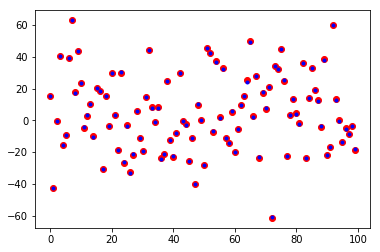

In [189]:
plt.plot(y_true_plot, 'ro')
plt.plot(y_hat_plot, 'b.')